In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heart-failure-clinical-data/heart_failure_clinical_records_dataset.csv


In [2]:
# Read the data
heart_failure = pd.read_csv("../input/heart-failure-clinical-data/heart_failure_clinical_records_dataset.csv")
heart_failure.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


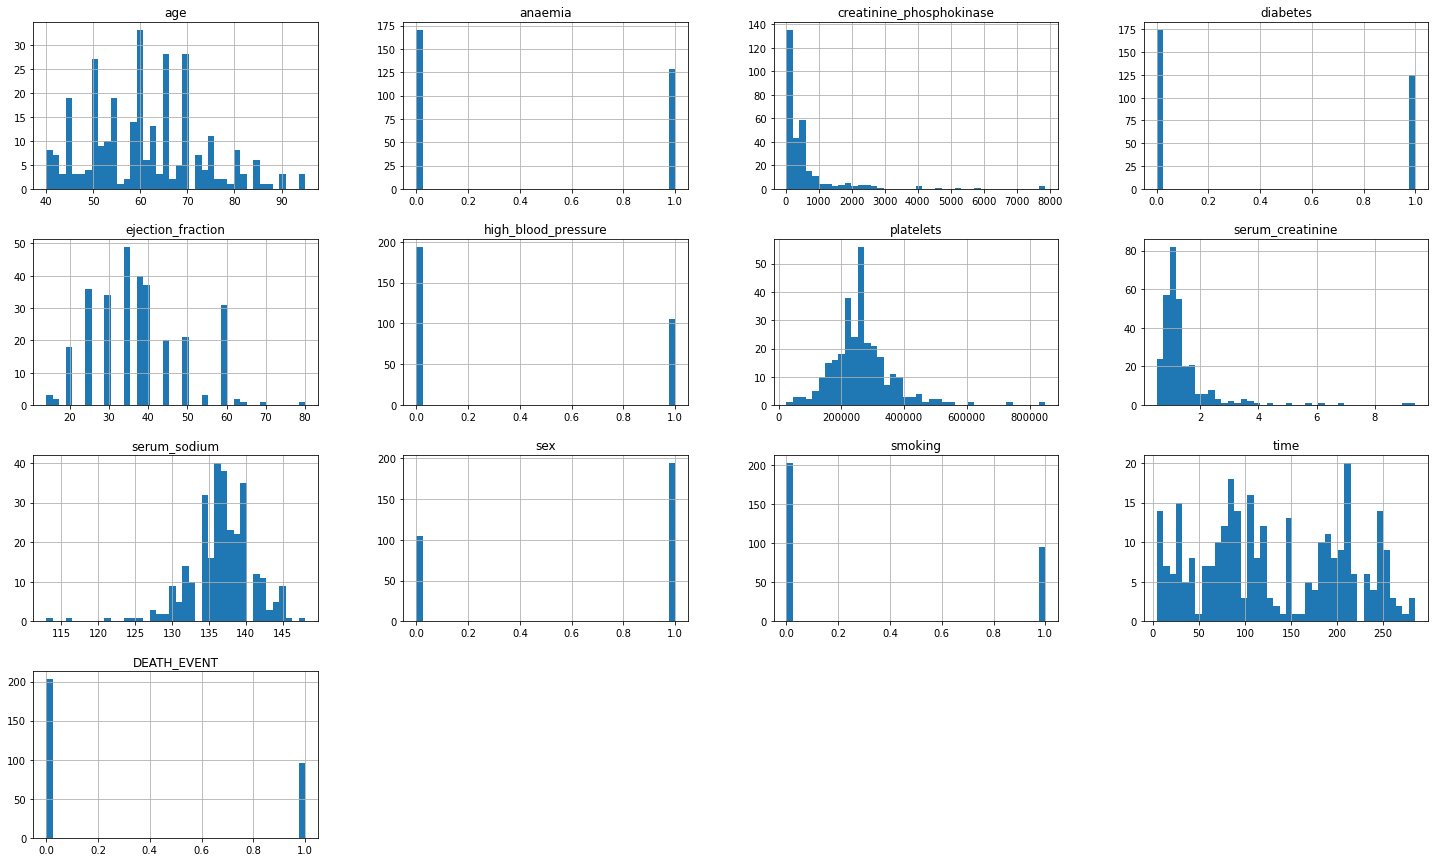

In [3]:
# Visualize the features distribution
import matplotlib.pyplot as plt

heart_failure.hist(bins=40,figsize=(25,15))
plt.show()

The dataset has class imbalance. One needs to take this into account henceforth to avoid learning to predict all instances as negative. Furthermore, now, it would be interesting to see which variables are actually correlated to the death event. One idea is to plot a correlation matrix. Let's try that

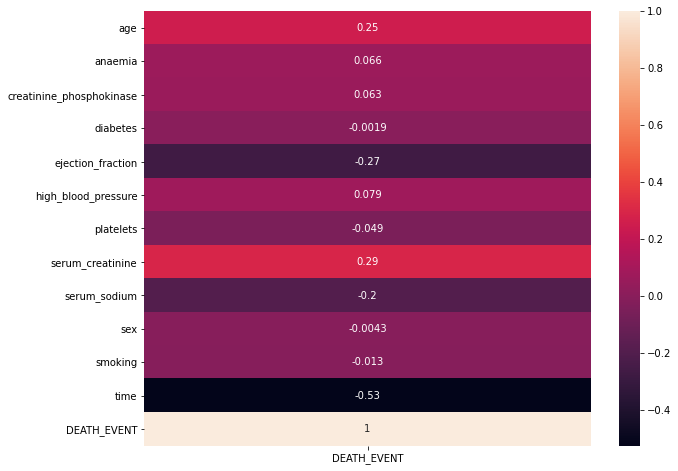

In [4]:
import seaborn as sns

corr = heart_failure.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr[['DEATH_EVENT']], annot = True)
plt.show()


While this does seem to give a nice overview of the strength of each feature on the death events, but I think we should be careful. Diabetes seems to have almost negligible effect on heart failure, but it is of common knowledge that diabetic patients are more prone to to heart disease. 

In [5]:
# Split the dataset into train and test. Split in stratified fashion to account for class imbalance
from sklearn.model_selection import train_test_split

train_set,test_set = train_test_split(heart_failure,test_size=0.2,random_state=42, shuffle = 1, stratify = heart_failure['DEATH_EVENT'])
heart = train_set.copy()

In [6]:
heart_data = heart.drop('DEATH_EVENT',axis=1)
heart_data_labels = heart['DEATH_EVENT'].copy()

In [7]:
from sklearn.preprocessing import StandardScaler
#Scaling the data - Feature scaling
std_scaler = StandardScaler()
heart_data_scaled = std_scaler.fit_transform(heart_data)

# SGDClassifier

In [8]:
from sklearn.linear_model import SGDClassifier,LogisticRegression

sgd_clf = SGDClassifier()
sgd_clf.fit(heart_data_scaled,heart_data_labels)

SGDClassifier()

In [9]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix,precision_score,recall_score,roc_curve,roc_auc_score

heart_pred = cross_val_predict(sgd_clf,heart_data_scaled,heart_data_labels,cv=3)
print(confusion_matrix(heart_data_labels,heart_pred))
print(precision_score(heart_data_labels,heart_pred))
print(recall_score(heart_data_labels,heart_pred))

[[130  32]
 [ 36  41]]
0.5616438356164384
0.5324675324675324


It is nice to predict all the positive death events correctly (high TPR). But a model that just learns to predict everything as positive is also not good (high FPR). So a good model in this class imbalance case would be to have a high area under the graph in ROC curve. This metric will be used here:

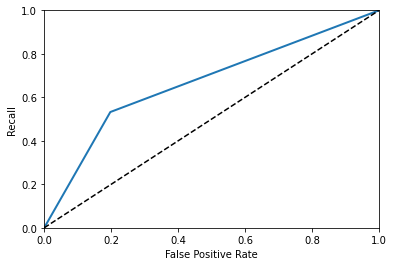

In [10]:
fpr,tpr,threshold = roc_curve(heart_data_labels,heart_pred)

def plot_ROC_curve(fpr,tpr,label=None):
    plt.plot(fpr,tpr,linewidth=2,label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('Recall')

plot_ROC_curve(fpr,tpr)
plt.show()

In [11]:
roc_auc_score(heart_data_labels,heart_pred)

0.6674683341350007

# LogisticRegressor

In [12]:
log_reg = LogisticRegression()
log_reg.fit(heart_data,heart_data_labels)

LogisticRegression()

In [13]:
heart_pred_log = cross_val_predict(log_reg,heart_data_scaled,heart_data_labels,cv=3)
print(confusion_matrix(heart_data_labels,heart_pred))
print(precision_score(heart_data_labels,heart_pred))
print(recall_score(heart_data_labels,heart_pred))

[[130  32]
 [ 36  41]]
0.5616438356164384
0.5324675324675324


In [14]:
roc_auc_score(heart_data_labels,heart_pred_log)

0.7786996953663621

# RandomForest

In [15]:
from sklearn.ensemble import RandomForestClassifier

forest_clas = RandomForestClassifier()
forest_clas.fit(heart_data_scaled,heart_data_labels)

RandomForestClassifier()

In [16]:
heart_pred_forest = cross_val_predict(forest_clas,heart_data_scaled,heart_data_labels,cv=3)
print(confusion_matrix(heart_data_labels,heart_pred_forest))
print(precision_score(heart_data_labels,heart_pred_forest))
print(recall_score(heart_data_labels,heart_pred_forest))

[[149  13]
 [ 26  51]]
0.796875
0.6623376623376623


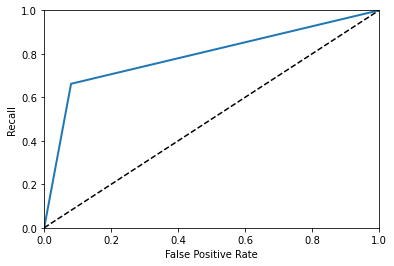

In [17]:
fpr1,tpr1,threshold1 = roc_curve(heart_data_labels,heart_pred_forest)

plot_ROC_curve(fpr1,tpr1)
plt.show()

In [18]:
roc_auc_score(heart_data_labels,heart_pred_forest)

0.7910453743787077

# KNeighbors

In [19]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
knn_clf.fit(heart_data,heart_data_labels)

KNeighborsClassifier()

In [20]:
heart_pred_knn = cross_val_predict(knn_clf,heart_data_scaled,heart_data_labels,cv=3)
print(confusion_matrix(heart_data_labels,heart_pred_knn))
print(precision_score(heart_data_labels,heart_pred_knn))
print(recall_score(heart_data_labels,heart_pred_knn))

[[152  10]
 [ 45  32]]
0.7619047619047619
0.4155844155844156


In [21]:
roc_auc_score(heart_data_labels,heart_pred_knn)

0.6769280102613436

RandomForestClassifier is much better than Logistic regression. However it is overfitting the training set. We try attempting fine tuning the model.

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

parameters = [{'n_estimators':[10,100,500,1000],'max_depth':[3,5,8,10,15],'max_features':['log2','auto','sqrt']}]
auc_scorer = make_scorer(roc_auc_score)
grid_search = GridSearchCV(forest_clas,parameters,scoring=auc_scorer)
grid_search = grid_search.fit(heart_data_scaled,heart_data_labels)
forest_clas = grid_search.best_estimator_
heart_predictions = cross_val_predict(forest_clas,heart_data,heart_data_labels,cv=3)
forest_score = roc_auc_score(heart_data_labels,heart_predictions)
print(forest_score)

0.8009459676126344


In [23]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'],cvres['params']):
    print(mean_score,params)

0.7772537878787877 {'max_depth': 3, 'max_features': 'log2', 'n_estimators': 10}
0.7830871212121212 {'max_depth': 3, 'max_features': 'log2', 'n_estimators': 100}
0.812651515151515 {'max_depth': 3, 'max_features': 'log2', 'n_estimators': 500}
0.8187121212121212 {'max_depth': 3, 'max_features': 'log2', 'n_estimators': 1000}
0.7993181818181819 {'max_depth': 3, 'max_features': 'auto', 'n_estimators': 10}
0.8066287878787879 {'max_depth': 3, 'max_features': 'auto', 'n_estimators': 100}
0.8125568181818181 {'max_depth': 3, 'max_features': 'auto', 'n_estimators': 500}
0.8125568181818181 {'max_depth': 3, 'max_features': 'auto', 'n_estimators': 1000}
0.7621022727272727 {'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 10}
0.7933901515151515 {'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 100}
0.8124621212121212 {'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 500}
0.8156818181818182 {'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 1000}
0.7593939393939394 {'max_dept

Now we try the fine tuned model with the test data and see how it performs

In [24]:
from sklearn.metrics import accuracy_score

final_model = forest_clas

# Use the same scaler as we used for training data
X_test = test_set.drop('DEATH_EVENT',axis=1)
y_test = test_set['DEATH_EVENT']
X_test_scaled = std_scaler.transform(X_test)

final_predictions = final_model.predict(X_test_scaled)
roc_auc_score(y_test,final_predictions)

0.7913992297817715